In [1]:
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import seaborn as sns

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Input, Dropout,Dense,RepeatVector,TimeDistributed

from utils import *

import warnings
warnings.filterwarnings('ignore')

Start date is:  1962-01-02 00:00:00
End date is:  2021-11-03 00:00:00


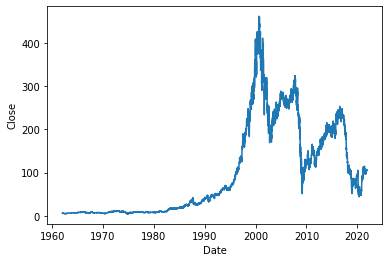

In [2]:
dataframe = pd.read_csv('Data/Stocks/GE.csv')
df = dataframe.copy()
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])

sns.lineplot(x=df['Date'], y=df['Close'])

print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

In [4]:
train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])


In [5]:
seq_size = 30  # Number of time steps to look back 
trainX, trainY = to_sequences_xy(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences_xy(test[['Close']], test['Close'], seq_size)

In [22]:
# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
seq_size = trainX.shape[1]

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 128)           66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

#### Model Fitting

In [23]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
297/297 [==============================] - 14s 38ms/step - loss: 0.3061 - val_loss: 2.1154
Epoch 2/10
297/297 [==============================] - 12s 40ms/step - loss: 0.0028 - val_loss: 0.3038
Epoch 3/10
297/297 [==============================] - 11s 37ms/step - loss: 0.0013 - val_loss: 0.1132
Epoch 4/10
297/297 [==============================] - 12s 39ms/step - loss: 0.0010 - val_loss: 0.0383
Epoch 5/10
297/297 [==============================] - 13s 45ms/step - loss: 7.7293e-04 - val_loss: 0.0478
Epoch 6/10
297/297 [==============================] - 14s 47ms/step - loss: 8.1456e-04 - val_loss: 0.0338
Epoch 7/10
297/297 [==============================] - 11s 36ms/step - loss: 6.4381e-04 - val_loss: 0.0389
Epoch 8/10
297/297 [==============================] - 11s 37ms/step - loss: 6.7289e-04 - val_loss: 0.0243
Epoch 9/10
297/297 [==============================] - 11s 38ms/step - loss: 5.4589e-04 - val_loss: 0.0647
Epoch 10/10
297/297 [==============================] - 13s 44m

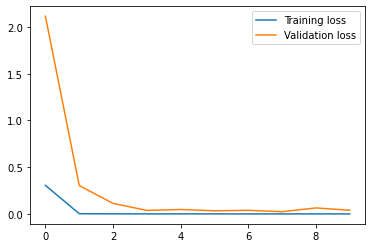

In [24]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [25]:
model.evaluate(testX, testY)

140/140 [==============================] - 2s 13ms/step - loss: 0.0025


0.002482811687514186

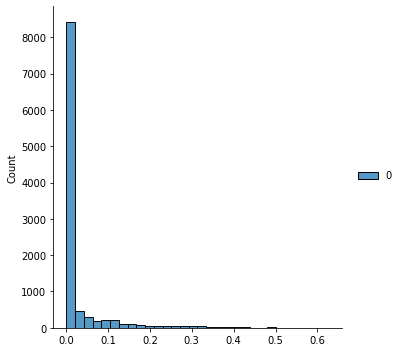

In [26]:
###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
sns.displot(trainMAE, bins=30)
plt.show()

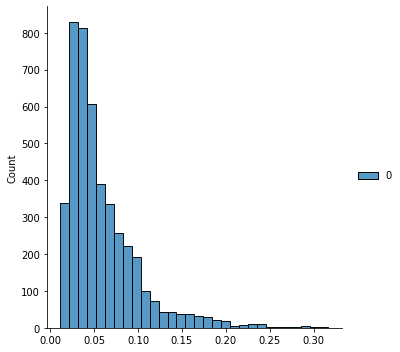

In [30]:
max_trainMAE = 0.2  #or Define 90% value of max as threshold.
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
sns.displot(testMAE, bins=30)
plt.show()

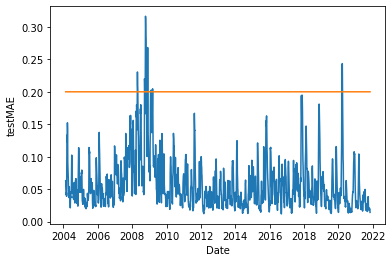

In [31]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])
plt.show()


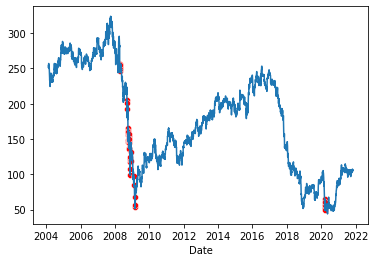

In [32]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), color='r')
plt.show()